<a href="https://colab.research.google.com/github/Zhou-spec/Option_Market_Making/blob/main/option_market_making_ac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as scistat


class ResidualBlock_Conv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock_Conv, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        out += residual
        out = self.relu(out)

        return out

class ResNet_Conv(nn.Module):
    def __init__(self, m, n, output_size, input_channels, output_channels, num_blocks, final_act):
        super(ResNet_Conv, self).__init__()

        self.fc = nn.Linear(1 + m * n, 1024)
        self.conv1 = nn.Conv1d(input_channels, output_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.final_act = final_act

        self.blocks = nn.ModuleList()
        for _ in range(num_blocks):
            self.blocks.append(ResidualBlock_Conv(output_channels, output_channels))

        self.conv2 = nn.Conv1d(output_channels, input_channels, kernel_size=3, stride=1, padding=1)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, output_size)

    def forward(self, t, q):
        q = q.view(-1)
        x = torch.cat((t, q), dim=0)
        out = self.fc(x)
        out = out.unsqueeze(0)
        out = out.unsqueeze(0)
        out = self.conv1(out)
        out = self.relu(out)

        for block in self.blocks:
            out = block(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = out.squeeze()
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.fc5(out)
        out = 0.3 * self.final_act(out)


        return out


# this Gaussian policy implementation is for the actor-critic algorithm
# modeling the mean of bid-ask policy as a neural network directly
def Gaussian_Policy(net, t, q, A, B, gamma):
    number = A.shape[0] * A.shape[1]
    mean = net.forward(t, q) # the output for the neural network is of dim 2*m*n
    bid_mean = mean[:number]
    ask_mean = mean[number:]
    variance = (gamma / (2 * B)).view(-1)
    std = torch.sqrt(variance)
    bid_matrix = torch.normal(bid_mean, std).view(A.shape)
    ask_matrix = torch.normal(ask_mean, std).view(A.shape)

    return bid_matrix, ask_matrix


def Stock_Prices_Simulation(T, dt, mu, sigma, S0):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    S = torch.zeros(N).to(device)
    S[0] = S0
    for count in range(N - 1):
        S[count + 1] = S[count] + mu * S[count] * dt + sigma * S[count] * torch.sqrt(dt) * torch.normal(0.0, 1.0, size=(1,)).to(device)
    return S


def Market_Order_Simulation(dt, A, B, bid_matrix, ask_matrix):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    orders = torch.zeros(bid_matrix.shape).to(device)
    buy_orders = torch.zeros(bid_matrix.shape).to(device)
    sell_orders = torch.zeros(bid_matrix.shape).to(device)
    m = bid_matrix.shape[0]
    n = bid_matrix.shape[1]
    for i in range(m):
        for j in range(n):
            intensity_bid = A[i, j] - B[i, j] * bid_matrix[i, j]
            intensity_ask = A[i, j] - B[i, j] * ask_matrix[i, j]
            buy_orders[i, j] = torch.poisson(intensity_bid * dt)
            sell_orders[i, j] = torch.poisson(intensity_ask * dt)
            orders[i, j] = buy_orders[i, j] - sell_orders[i, j]

    return orders, buy_orders, sell_orders


def Train_Data_Simulation(T, dt, A, B, gamma, net):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = A.shape[0]
    n = A.shape[1]
    q = torch.zeros((N, m, n)).to(device)
    buy = torch.zeros((N, m, n)).to(device)
    sell = torch.zeros((N, m, n)).to(device)
    bid = torch.zeros((N, m, n)).to(device)
    ask = torch.zeros((N, m, n)).to(device)

    for count in range(N - 1):
        t = count * dt
        bid_matrix, ask_matrix = Gaussian_Policy(net, t, q[count], A, B, gamma)
        orders, buy_orders, sell_orders = Market_Order_Simulation(dt, A, B, bid_matrix, ask_matrix)
        buy[count] = buy_orders
        sell[count] = sell_orders
        q[count + 1] = q[count] + orders
        bid[count] = bid_matrix
        ask[count] = ask_matrix

    return q, buy, sell, bid, ask


from torch.distributions.normal import Normal

#the following are option greeks' functions
def d1(S, K, r, sigma, T):
    return (torch.log(S/K) + (r+sigma*sigma/2)*T)/(sigma*math.sqrt(T))

def d2(S, K, r, sigma, T):
    return d1(S, K, r, sigma, T) - sigma*torch.sqrt(T)

def Gamma(S, K, r, sigma, T):
    # use torch module to get teh pdf of normal distribution
    normal_dist = Normal(0, 1)
    return normal_dist.log_prob(d1(S, K, r, sigma, T)).exp() /(S*sigma*torch.sqrt(T))

def Theta(S, K, r, sigma, T):
    normal_dist = Normal(0, 1)
    aux1 = -S * normal_dist.log_prob(d1(S, K, r, sigma, T)).exp() * sigma / (2*torch.sqrt(T))
    aux2 = -r*K*torch.exp(-r*T)*normal_dist.cdf(d2(S, K, r, sigma, T))
    return aux1+aux2

# here, the S will be trace of the stock price
def Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes):
    N = int(T / dt)
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    theta = torch.zeros((N, m, n)).to(device)
    for count in range(N):
        t = count * dt
        for i in range(m):
            for j in range(n):
                theta[count, i, j] = Theta(S[count], Strikes[i], r, Vol_surface[i, j], Maturities[j] - t)
    return theta

# here, the S will be trace of the stock price
def Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    N = int(T / dt)
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    gamma = torch.zeros((N, m, n)).to(device)
    for count in range(N):
        t = count * dt
        for i in range(m):
            for j in range(n):
                gamma[count, i, j] = Gamma(S[count], Strikes[i], r, Vol_surface[i, j], Maturities[j] - t)
    return gamma



def reward(q, buy, sell, S, r, T, dt, Maturities, Strikes, Vol_surface, Policy_Net, gamma, B, Value_Net):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    reward = torch.zeros(N).to(device)
    Opt_Theta = Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes)
    Opt_Gamma = Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes)
    for count in range(N - 1):
        t = count * dt
        mean = Policy_Net(t, q[count])
        profit = torch.sum(buy[count] * (mean[ : m*n].view(Vol_surface.shape)) + sell[count] * (mean[m*n :].view(Vol_surface.shape)))

        Theta = Opt_Theta[count] * q[count] * dt
        Gamma = 0.5 * Opt_Gamma[count] * q[count] * dt
        reward[count] = profit + torch.sum(Theta) + torch.sum(Gamma) - gamma * ((m * n * 1.79817986835) + torch.sum(torch.log(gamma / (2 * B)))) * dt
        td_error = Value_Net(t + dt, q[count + 1]) - Value_Net(t, q[count])
        reward[count] += td_error.view(reward[count].shape)

    return reward


def critic_loss(q, buy, sell, S, r, T, dt, Maturities, Strikes, Vol_surface, Policy_Net, gamma, B, Value_Net):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    m = Vol_surface.shape[0]
    n = Vol_surface.shape[1]
    r = reward(q, buy, sell, S, r, T, dt, Maturities, Strikes, Vol_surface, Policy_Net, gamma, B, Value_Net)
    loss = 0.5 * torch.sum(r ** 2)
    return loss


def probability(Policy_Net, q, T, dt, bid, ask, B, gamma):
    N = int(T / dt)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    m = bid.shape[0]
    n = bid.shape[1]
    prob = torch.zeros(N).to(device)
    for count in range(N - 1):
        t = count * dt
        mean = Policy_Net(t, q[count])
        bid_matrix = bid[count].view(-1)
        ask_matrix = ask[count].view(-1)
        bid_ask_matrix = torch.cat((bid_matrix, ask_matrix), 0)
        diag = torch.cat((gamma / (2 * B.view(-1)), gamma / (2 * B.view(-1))), 0)
        cov = torch.diag(diag)
        prob[count] = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov).log_prob(bid_ask_matrix)

    return prob


def actor_loss(Policy_Net, q, T, dt, bid, ask, B, gamma, buy, sell, S, r, Maturities, Strikes, Vol_surface, Value_Net):
    prob = probability(Policy_Net, q, T, dt, bid, ask, B, gamma)
    r = reward(q, buy, sell, S, r, T, dt, Maturities, Strikes, Vol_surface, Policy_Net, gamma, B, Value_Net).detach()
    loss = torch.sum(prob * r)
    return loss



# call option price function with S, K, T, r, sigma
def call_option_price(S, K, T, r, sigma):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * torch.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * torch.distributions.normal.Normal(0, 1).cdf(d1) - K * torch.exp(-r * T) * torch.distributions.normal.Normal(0, 1).cdf(d2)



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
A = torch.tensor([[36, 34, 32, 30], [46, 44, 42, 40], [56, 54, 52, 50], [46, 44, 42, 40], [36, 34, 32, 30]]).to(device)
B = torch.tensor([[3, 3, 3, 3], [4, 4, 4, 4], [5, 5, 5, 5], [4, 4, 4, 4], [3, 3, 3, 3]]).to(device)
gamma = torch.tensor([0.1]).to(device)
T = torch.tensor([1]).to(device)
dt = torch.tensor([0.01]).to(device)
mu = torch.tensor([0.01]).to(device)
sigma = torch.tensor([0.05]).to(device)
S0 = torch.tensor([100]).to(device)
S = Stock_Prices_Simulation(T, dt, mu, sigma, S0)
m = 5
n = 4
q = torch.zeros(m, n).to(device)
Vol_surface = torch.tensor([[0.2, 0.2, 0.18, 0.18], [0.14, 0.14, 0.12, 0.12], [0.1, 0.1, 0.08, 0.08], [0.14, 0.14, 0.12, 0.12], [0.2, 0.2, 0.18, 0.18]]).to(device)
Strikes = torch.tensor([90, 95, 100, 105, 110]).to(device) # means i in the code
Maturities = torch.tensor([2, 3, 4, 5]).to(device) # means j in the code
r = torch.tensor([0]).to(device)


In [ ]:
policy_net = ResNet_Conv(m, n, 2 * m * n, 1, 1, 2, nn.Sigmoid()).to(device)
value_net = ResNet_Conv(m, n, 1, 1, 1, 2, nn.Identity()).to(device)

optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.001)
optimizer_value = torch.optim.Adam(value_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma = 0.95)
scheduler_value = torch.optim.lr_scheduler.StepLR(optimizer_value, step_size = 5, gamma = 0.95)

V = []
P = []

stock = []
for _ in range(50):
  S = Stock_Prices_Simulation(T, dt, mu, sigma, S0)
  stock.append(S)

batch = 5

for epoch in range(30):
    optimizer.zero_grad()
    optimizer_value.zero_grad()
    S = stock[np.random.randint(50)]

    q, buy, sell, bid, ask = Train_Data_Simulation(T, dt, A, B, gamma, policy_net)
    p_loss = actor_loss(policy_net, q, T, dt, bid, ask, B, gamma, buy, sell, S, r, Maturities, Strikes, Vol_surface, value_net)
    v_loss = critic_loss(q, buy, sell, S, r, T, dt, Maturities, Strikes, Vol_surface, policy_net, gamma, B, value_net)
    loss = p_loss + v_loss
    loss.backward()
    optimizer.step()
    optimizer_value.step()
    scheduler.step()
    scheduler_value.step()
    print(epoch)
    print(p_loss.item())
    print(v_loss.item())

    V.append(v_loss.item())
    P.append(p_loss.item())

0
6580.07275390625
283.2544250488281
1
6527.6484375
272.6626281738281
2
5184.94921875
185.3099365234375
3
6999.5537109375
305.3823547363281
4
7491.24365234375
330.0914001464844
5
5700.458984375
195.21417236328125
6
3849.2548828125
105.90756225585938
7
1220.6893310546875
39.617454528808594
8
4854.77197265625
148.87112426757812
9
5849.5595703125
217.9080352783203
10
369.0302429199219
23.927997589111328
11
3960.261962890625
107.23387908935547
12
2550.85888671875
53.920066833496094
13
1756.700439453125
32.1090087890625
14
4518.6298828125
140.70901489257812
15
330.80413818359375
17.636812210083008
16
343.7234191894531
11.387102127075195
17
1910.846435546875
28.690195083618164
18
2044.181396484375
29.009143829345703
19
190.06674194335938
14.716693878173828
20
1458.792724609375
21.25204849243164
21
1674.6224365234375
25.768413543701172
22
-60.54819869995117
11.75787353515625
23
1312.388671875
19.630393981933594
24
-48.64213562011719
5.8827009201049805
25
-429.3734130859375
18.862525939941406


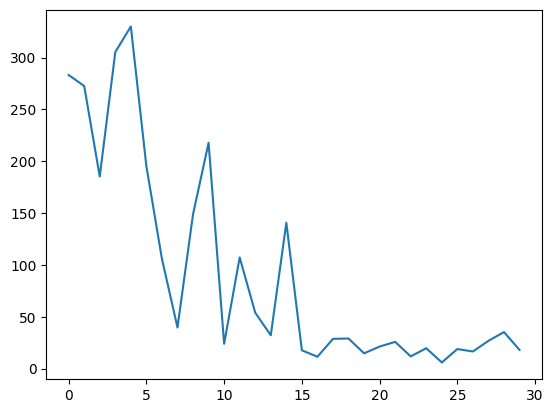

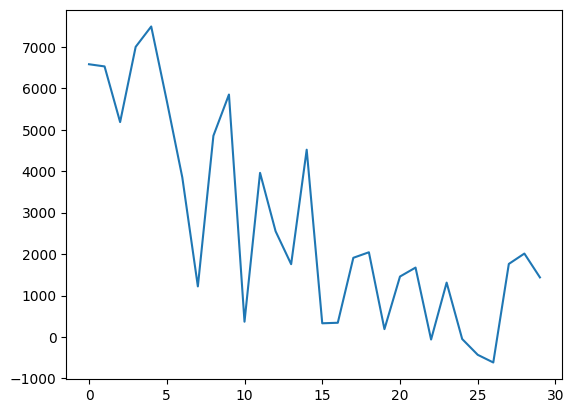

In [ ]:
plt.figure()
plt.plot(V)
plt.show()

plt.figure()
plt.plot(P)
plt.show()


In [ ]:
loss_v = np.array(V)
loss_p = np.array(P)
np.save('loss_v.npy', loss_v)
np.save('loss_p.npy', loss_p)

In [ ]:
def final_return(q, buy, sell, bid, ask, T, dt, Vol_surface, S, r, Maturities, Strikes):
    N = int(T / dt)
    profit = 0

    profit += torch.sum(buy * bid + sell * ask)
    profit += (torch.sum((Options_Theta(Vol_surface, S, r, T, dt, Maturities, Strikes) + 0.5 * Options_Gamma(Vol_surface, S, r, T, dt, Maturities, Strikes)) * q) * dt).item()

    return profit.item()

In [ ]:


final_returns = []
for count in range(50):
  q, buy, sell, bid, ask = Train_Data_Simulation(T, dt, A, B, gamma, policy_net)
  final_returns.append(final_return(q, buy, sell, bid, ask, T, dt, Vol_surface, S, r, Maturities, Strikes))



In [ ]:
for count in range(50):
  q, buy, sell, bid, ask = Train_Data_Simulation(T, dt, A, B, gamma, policy_net)
  final_returns.append(final_return(q, buy, sell, bid, ask, T, dt, Vol_surface, S, r, Maturities, Strikes))

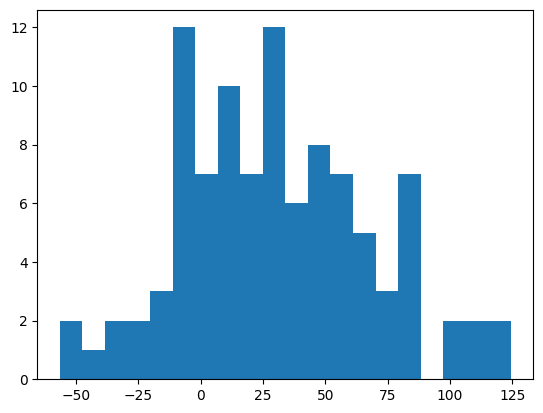

In [ ]:
plt.figure()
plt.hist(final_returns, bins = 20)
plt.show()

In [ ]:
q1 = torch.tensor([[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]).to(device)
q2 = torch.tensor([[3 * abs(2 - i) + j for j in range(4)] for i in range(5)]).to(device)
q3 = torch.tensor([[3, 4, -5, -6], [1, 2, -3, -4], [0, 1, -1, 1], [1, -2, 3, 4], [2, -3, 4, 5]]).to(device)
inventory = torch.zeros(3, 5, 4).to(device)
inventory[0] = q1
inventory[1] = q2
inventory[2] = q3


bid_ask_first = policy_net.forward(torch.tensor([0.0]).to(device), q1)
bid_ask_second = policy_net.forward(torch.tensor([0.5]).to(device), q2)
bid_ask_third = policy_net.forward(torch.tensor([0.0]).to(device), q3)


print(bid_ask_first)


tensor([1.5273e-05, 6.0572e-06, 6.0883e-05, 1.0897e-05, 9.5321e-05, 6.6789e-04,
        4.2633e-04, 3.0500e-04, 5.2232e-05, 1.5419e-04, 1.9577e-07, 8.3322e-07,
        1.3937e-03, 9.2829e-05, 8.8526e-02, 4.0961e-05, 6.7014e-05, 1.4698e-04,
        2.9820e-01, 1.5254e-05, 6.3222e-05, 5.9475e-07, 2.4716e-06, 7.6150e-05,
        3.4210e-04, 5.8940e-04, 4.2803e-04, 8.7606e-07, 1.6049e-06, 1.0830e-05,
        2.0822e-03, 2.2775e-05, 7.7919e-06, 1.7873e-05, 2.9612e-01, 8.2509e-03,
        1.1576e-05, 2.9994e-01, 2.6528e-05, 7.3406e-03], device='cuda:0',
       grad_fn=<MulBackward0>)


In [ ]:



a = np.array(final_returns)
np.save('final_returns_ac.npy', a)

bid_ask_mat = [bid_ask_first.cpu().detach().numpy(), bid_ask_second.cpu().detach().numpy(), bid_ask_third.cpu().detach().numpy()]
print(bid_ask_mat)
bid_ask_mat = np.array(bid_ask_mat)
print(bid_ask_mat.shape)
print(bid_ask_mat)
b = np.array(bid_ask_mat)
np.save('bid_ask_matrix_ac.npy', b)

[array([1.5272863e-05, 6.0571865e-06, 6.0883322e-05, 1.0897448e-05,
       9.5320684e-05, 6.6789286e-04, 4.2632731e-04, 3.0499627e-04,
       5.2232055e-05, 1.5419400e-04, 1.9577233e-07, 8.3321811e-07,
       1.3937460e-03, 9.2828908e-05, 8.8526055e-02, 4.0960804e-05,
       6.7014429e-05, 1.4698172e-04, 2.9819602e-01, 1.5253837e-05,
       6.3221858e-05, 5.9475099e-07, 2.4716278e-06, 7.6149787e-05,
       3.4210310e-04, 5.8940297e-04, 4.2803425e-04, 8.7605838e-07,
       1.6048714e-06, 1.0829849e-05, 2.0822028e-03, 2.2774642e-05,
       7.7918648e-06, 1.7872957e-05, 2.9611778e-01, 8.2508577e-03,
       1.1575912e-05, 2.9994234e-01, 2.6528493e-05, 7.3406161e-03],
      dtype=float32), array([5.0581965e-09, 9.6270758e-10, 5.8526801e-08, 2.8162557e-09,
       1.3431620e-07, 4.9864830e-06, 2.1278418e-06, 1.2030292e-06,
       4.5909484e-08, 2.9914742e-07, 1.7533361e-12, 2.6247110e-11,
       1.9168328e-05, 1.3191253e-07, 5.3194940e-02, 2.7599794e-08,
       7.3563363e-08, 2.9321342e-07, 2